# W205 Project 3
## AGM Business Improvement

### Team Members
#### Siddhartha Gupte
#### Kumar Kallurupalli
#### Tigran Poladian

Data science demonstration for the AGM data science team using the BART transportation system.

### BART TRACK LAYOUT

![Bart Map](../data/bart_map.png)

In [30]:
pip install geopy

     |████████████████████████████████| 119 kB 4.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [164]:
import neo4j
import csv
import math
import numpy as np
import pandas as pd

import psycopg2

import pymongo

import json

import geopy
from geopy.geocoders import Nominatim

from matplotlib import pyplot as plt

### Support Functions
Reused from W205 Code / Labs

In [35]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

cursor = connection.cursor()

In [36]:
#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

In [37]:
def my_read_csv_file(file_name, limit):
    "read the csv file and print only the first limit rows"
    
    csv_file = open(file_name, "r")
    
    csv_data = csv.reader(csv_file)
    
    i = 0
    
    for row in csv_data:
        i += 1
        if i <= limit:
            print(row)
            
    print("\nPrinted ", min(limit, i), "lines of ", i, "total lines.")

### Drop tables, create and load from CSV files

In [38]:
connection.rollback()

query = """

drop table if exists stations;
"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

In [39]:
connection.rollback()

query = """

drop table if exists lines;

"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

In [40]:
connection.rollback()

query = """

drop table if exists travel_times;

"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

In [41]:
connection.rollback()

query = """

create table stations (
    station varchar(32),
    latitude numeric(9,6),
    longitude numeric(9,6),
    transfer_time numeric(3),
    primary key (station)
);

"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

In [42]:
connection.rollback()

query = """

create table lines (
    line varchar(6),
    sequence numeric(2),
    station varchar(32),
    primary key (line, sequence)
);

"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

In [43]:
connection.rollback()

query = """

create table travel_times (
    station_1 varchar(32),
    station_2 varchar(32),
    travel_time numeric(3),
    primary key (station_1, station_2)
);

"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

In [44]:
# NOTE: use location of data files
connection.rollback()

query = """

copy stations
from '/user/projects/w205_project3/data/stations.csv' delimiter ',' NULL '' csv header;

"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

In [45]:
connection.rollback()

query = """

copy lines
from '/user/projects/w205_project3/data/lines.csv' delimiter ',' NULL '' csv header;

"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

In [46]:
connection.rollback()

query = """

copy travel_times
from '/user/projects/w205_project3/data/travel_times.csv' delimiter ',' NULL '' csv header;

"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

### Establish Neo4j connection and helper functions

In [47]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","w205"))
session = driver.session(database="neo4j")

In [48]:
def my_neo4j_wipe_out_database():
    "wipe out database by deleting all nodes and relationships"
    
    query = "match (node)-[relationship]->() delete node, relationship"
    session.run(query)
    
    query = "match (node) delete node"
    session.run(query)
  
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

def my_neo4j_create_node(station_name):
    "create a node with label Station"
    
    query = """
    
    CREATE (:Station {name: $station_name})
    
    """
    
    session.run(query, station_name=station_name)

def my_neo4j_create_relationship_one_way(from_station, to_station, weight):
    "create a relationship one way between two stations with a weight"
    
    query = """
    
    MATCH (from:Station), 
          (to:Station)
    WHERE from.name = $from_station and to.name = $to_station
    CREATE (from)-[:LINK {weight: $weight}]->(to)
    
    """
    
    session.run(query, from_station=from_station, to_station=to_station, weight=weight)

def my_neo4j_create_relationship_two_way(from_station, to_station, weight):
    "create relationships two way between two stations with a weight"
    
    query = """
    
    MATCH (from:Station), 
          (to:Station)
    WHERE from.name = $from_station and to.name = $to_station
    CREATE (from)-[:LINK {weight: $weight}]->(to),
           (to)-[:LINK {weight: $weight}]->(from)
    
    """
    
    session.run(query, from_station=from_station, to_station=to_station, weight=weight)



In [49]:
my_neo4j_wipe_out_database()

### Create graphs from csv station files

#### Query the list of stations and create the departure and arrival nodes in the graph

Use the query from 3.2.1 "Query the list of stations"

For each station X, create two nodes:
* depart X
* arrive X

Use the function my_neo4j_create_node() defined above

For example, West Oakland:
* my_neo4j_create_node('depart West Oakland')
* my_neo4j_create_node('arrive West Oakland')

In [50]:
connection.rollback()

query = """

select station
from stations
order by station

"""

cursor.execute(query)

connection.rollback()

rows = cursor.fetchall()

for row in rows:
    
    station = row[0]
    
    my_neo4j_create_node('depart ' + station)
    my_neo4j_create_node('arrive ' + station)

#### Query the list of stations and the lines they serve, create line nodes, and create relationships between the line nodes and the departure and arrival nodes with weight 0

Use the query from "Query the list of stations and the lines they serve"

For each station X and each line Y that the station serves:
* Create a line node
* Create a relationship from the departure node to the line node with weight 0
* Create a relationship from the line node to the arrival node with weight 0

Use the function my_neo4j_create_relationship_one_way() defined above to create the relationships

In [51]:
connection.rollback()

query = """

select station, line
from lines
order by station, line

"""

cursor.execute(query)

connection.rollback()

rows = cursor.fetchall()

for row in rows:
    
    station = row[0]
    line = row[1]
    
    depart = 'depart ' + station
    arrive = 'arrive ' + station
    line_station = line + ' ' + station
    
    my_neo4j_create_node(line_station)
    my_neo4j_create_relationship_one_way(depart, line_station, 0)
    my_neo4j_create_relationship_one_way(line_station, arrive, 0)

#### Query the list of all possible line transfers and the transfer times, create a relationship for each transfer with the transfer time as the weight

Use the query from 3.2.5 "Query the list of all possible line transfers and the transfer times"

For each station X, from line Y, to line Z, create a relationship from Y's line node to Z's line node with the weight set to the transfer time

In [52]:
connection.rollback()

query = """

select a.station, a.line as from_line, b.line as to_line, s.transfer_time
from lines a
     join lines b
       on a.station = b.station and a.line <> b.line 
     join stations s
       on a.station = s.station
order by 1, 2, 3

"""

cursor.execute(query)

connection.rollback()

rows = cursor.fetchall()

for row in rows:
    
    station = row[0]
    from_line = row[1]
    to_line = row[2]
    transfer_time = int(row[3])
    
    from_station = from_line + ' ' + station
    to_station = to_line + ' ' + station
    
    my_neo4j_create_relationship_one_way(from_station, to_station, transfer_time)

#### Query the list of all segments between each station and its adjoining stations, create a relationship for each segment both ways

Use the query from 3.2.7 "Query the list of all segments between each station and its adjoining stations"

For each segment from station X to station Y on line Z, create two relationships:
* From X's line node to Y's line node with travel time
* From Y's line node to X's line node with travel time

Use the function my_neo4j_create_relationship_two_way() defined above which will create both relationships 

In [53]:
connection.rollback()

query = """

select a.line, a.station as from_station, b.station as to_station, t.travel_time
from lines a
  join lines b
    on a.line = b.line and b.sequence = (a.sequence + 1)
  join travel_times t
    on (a.station = t.station_1 and b.station = t.station_2)
        or (a.station = t.station_2 and b.station = t.station_1)
order by line, from_station, to_station

"""

cursor.execute(query)

connection.rollback()

rows = cursor.fetchall()

for row in rows:
    
    line = row[0]
    from_station = line + ' ' + row[1]
    to_station = line + ' ' + row[2]
    travel_time = int(row[3])
    
    my_neo4j_create_relationship_two_way(from_station, to_station, travel_time)

### Begin PROJECT 3 CODE HERE

#### Define search algorithms

In [54]:
# ************************************************************************************************************
# Shortest Path algorithm from W205 labs - uses dijkstra
# ************************************************************************************************************
def my_neo4j_shortest_path(from_station, to_station):
    "given a from station and to station, run and print the shortest path"
    
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    query = "CALL gds.graph.project('ds_graph', 'Station', 'LINK', {relationshipProperties: 'weight'})"
    session.run(query)

    query = """

    MATCH (source:Station {name: $source}), (target:Station {name: $target})
    CALL gds.shortestPath.dijkstra.stream(
        'ds_graph', 
        { sourceNode: source, 
          targetNode: target, 
          relationshipWeightProperty: 'weight'
        }
    )
    YIELD index, sourceNode, targetNode, totalCost, nodeIds, costs, path
    RETURN
        gds.util.asNode(sourceNode).name AS from,
        gds.util.asNode(targetNode).name AS to,
        totalCost,
        [nodeId IN nodeIds | gds.util.asNode(nodeId).name] AS nodes,
        costs
    ORDER BY index

    """

    result = session.run(query, source=from_station, target=to_station)
    
    for r in result:
        
        total_cost = int(r['totalCost'])
        
        print("\n--------------------------------")
        print("   Total Cost: ", total_cost)
        print("   Minutes: ", round(total_cost / 60.0,1))
        print("--------------------------------")
        
        nodes = r['nodes']
        costs = r['costs']
        
        i = 0
        previous = 0
        
        for n in nodes:
            
            print(n + ", " + str(int(costs[i]) - previous)  + ", " + str(int(costs[i])))
            
            previous = int(costs[i])
            i += 1

In [55]:
# ***************************************************************************
# UNIT TEST dijkstra shortest path
# ***************************************************************************
my_neo4j_shortest_path("depart Ashby","arrive West Oakland")


--------------------------------
   Total Cost:  840
   Minutes:  14.0
--------------------------------
depart Ashby, 0, 0
red Ashby, 0, 0
red MacArthur, 240, 240
red 19th Street, 180, 420
red 12th Street, 120, 540
red West Oakland, 300, 840
arrive West Oakland, 0, 840


In [58]:
# ***************************************************************************
# Minimum Spanning Tree
# ***************************************************************************
def my_neo4j_mst(station):
    "wipe out mst relationships"
    
    query = "match (node)-[relationship:MST]->() delete relationship"
    session.run(query)
    
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    query = "CALL gds.graph.project('ds_graph', 'Station', 'LINK', {relationshipProperties: 'weight'})"
    session.run(query)
    
    query = """

    MATCH (n:Station {name: $source})
    CALL gds.alpha.spanningTree.minimum.write('ds_graph',
                                          {startNodeId: id(n),
                                           relationshipWeightProperty: 'weight',
                                           writeProperty: 'MST',
                                           weightWriteProperty: 'writeCost'
                                          }
                                         )
    YIELD preProcessingMillis, computeMillis, writeMillis, effectiveNodeCount
    RETURN preProcessingMillis, computeMillis, writeMillis, effectiveNodeCount;
    """
    session.run(query,source=station)
    
    query = """

    MATCH path = (n:Station {name: $source})-[:MST*]-()
    WITH relationships(path) AS rels
    UNWIND rels AS rel
    WITH DISTINCT rel AS rel
    RETURN startNode(rel).name AS source, endNode(rel).name AS destination, rel.writeCost AS cost

    """
    
    session.run(query,source=station)

In [59]:
# ******************************************************************************************
# UNIT TEST Minimum Spanning Tree
# ******************************************************************************************
my_neo4j_mst("depart Ashby")

In [60]:
# ******************************************************************************************
# ADD ADDITIONAL neo4j gds algorithms and use directly in the business scenarios
# ******************************************************************************************

#### Project To Do
1. Add modules to injest real time traffic data (use Redis or Redis fixed document as a proxy)
2. Import train schedules, planned route outages (use MongoDB)
3. Based on 1 and 2 create new graphs or modify cost / weights across nodes on existing graphs to eliminate paths and change time cost across nodes
4. Create 3 or more search, sort algorithms. Use the above as a template
5. Overlay Google maps API


#### Business Scenario 1

Select customers from the customers table who are within the BART transportation region

Run EDA using neo4j
   * Find clusters of customers, where concentrated most
   * Find nearest and furthest BART station to the clusters
   * Recommend pop up stores and new permanent locations

In [61]:
# ********************************************************************************************
# Business Scenario 1
#
# The customers tables is in postgres from Lab week 2 and Project 1
#
# ********************************************************************************************
rollback_before_flag = True
rollback_after_flag = True

query = """

select *
from customers
where city = 'Oakland' or city = 'Berkeley'

"""

df_customers = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df_customers

,customer_id,first_name,last_name,street,city,state,zip,closest_store_id,distance
0,1,Robb,Weaving,5 Ramsey Place,Oakland,CA,94609,1,1
1,2,Robby,Belliard,6 Londonderry Plaza,Oakland,CA,94609,1,1
2,3,Sadella,Caudrelier,548 Mcguire Parkway,Oakland,CA,94609,1,1
3,4,Holmes,Shimmings,99 Kennedy Court,Oakland,CA,94609,1,1
4,5,Beverley,Gubbin,51 Mcbride Drive,Oakland,CA,94609,1,1
...,...,...,...,...,...,...,...,...,...
3000,5302,Jory,Buss,3 Bonner Court,Oakland,CA,94621,1,9
3001,5303,Fonz,Gooder,25625 Lakeland Road,Oakland,CA,94621,1,9
3002,5304,Elora,MacKean,79655 Columbus Terrace,Oakland,CA,94621,1,9
3003,5305,Rafa,Mcettrick,76837 Green Way,Oakland,CA,94621,1,9


In [62]:
# ***********************************************************************************************************************
# Business Scenario 1
#
# Determine set of cities / zip codes within the BART track network
#
# Reverse zip code locator code from: 
# https://www.geeksforgeeks.org/find-the-location-with-specified-latitude-and-longitude-using-python/
# https://www.geeksforgeeks.org/get-the-city-state-and-country-names-from-latitude-and-longitude-using-python/?ref=rp
# **********************************************************************************************************************
# Initialize Nominatim API
geolocator = Nominatim(user_agent="geoapiExercises")
 
# Assign Latitude & Longitude
Latitude = "37.803608"
Longitude = "-122.420042"
 
# Displaying Latitude and Longitude
print("Latitude: ", Latitude)
print("Longitude: ", Longitude)

location = geolocator.reverse(Latitude+","+Longitude)
address = location.raw['address']
city = address.get('city', '')
state = address.get('state', '')
country = address.get('country', '')
code = address.get('country_code')
zipcode = address.get('postcode')
print('City : ',city)
print('State : ',state)
print('Country : ',country)
print('Zip Code : ', zipcode)


Latitude:  37.803608
Longitude:  -122.420042
City :  San Francisco
State :  California
Country :  United States
Zip Code :  90214


In [63]:
# ***********************************************************************************************************************
# Business Scenario 1
#
# Pseudocode:
#
# 1. Get list of unique zip codes associated to the set of BART stations using lat lon of station locations
#   -- lat lon from station table
# 2. From the customers table, find all customers with zip codes in the list of zip codes
# 3. Prepare histogram of customer counts per zip code
# 4. Create neo4j graph of nodes for zip codes along with graph of stations 
#   -- can we make the thickness of the node circle change based on population density?
#   -- connect zip code nodes to station nodes with links indicating distance so distance from zip to station within 
#      same zip should be 0
#   -- refine further ... use customer address (and google maps api?) to compute actual distance to each BART station
# 5. Can we use any of the centrality type measures for this scenario?
# **********************************************************************************************************************

In [120]:
# ***********************************************************************************************************************
# 1. Get list of unique zip codes associated to the set of BART stations using lat lon of station locations
#   -- lat lon from station table
# ***********************************************************************************************************************

connection.rollback()

query = """

select latitude, longitude
from stations

"""
cursor.execute(query)
connection.rollback()
rows = cursor.fetchall()

zips = []

for i, row in enumerate(rows):
    location = geolocator.reverse(str(row[0])+","+str(row[1]))
    address = location.raw['address']
    #city = address.get('city', '')
    #state = address.get('state', '')
    #country = address.get('country', '')
    #code = address.get('country_code')
    zipcode = address.get('postcode')
    #print(i)
    #print('City : ',city)
    #print('State : ',state)
    #print('Country : ',country)
    #print('Zip Code : ', zipcode)
    
    if zipcode == None:
      continue
    zips.append(zipcode)
    
zips_unique = set(zips)
print(zips_unique)

{'94080', '94509', '94520', '94609', '94587', '94539', '94030', '94102', '94015', '94614', '95133', '94530', '90104', '94536', '94066', '94804', '94601', '95035', '94565', '94704', '94104', '94014', '94168', '94112', '94607', '94580', '94597', '94143', '94111', '94128', '94549', '94596', '94612', '94621', '94577', '94541', '94563', '90103', '94703', '94544', '94588', '94702'}


In [153]:
# ***********************************************************************************************************************
# 2. From the customers table, find all customers with zip codes in the list of zip codes
# ***********************************************************************************************************************
#print(zips_unique)
#print(zips)

zip_list = ''
for z in zips_unique:
    zip_list += '\'' + str(z) + '\'' + ','

zip_list = zip_list[:-1] # remove extra last comma

rollback_before_flag = True
rollback_after_flag = True

query = """ 
select zip, count(*)
from customers
where zip in (%s)
group by zip
order by zip
""".replace("%s",zip_list)

df_customers = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df_customers

,zip,count
0,94014,41
1,94015,4
2,94030,10
3,94066,9
4,94080,9
5,94102,78
6,94104,5
7,94111,36
8,94112,40
9,94128,1


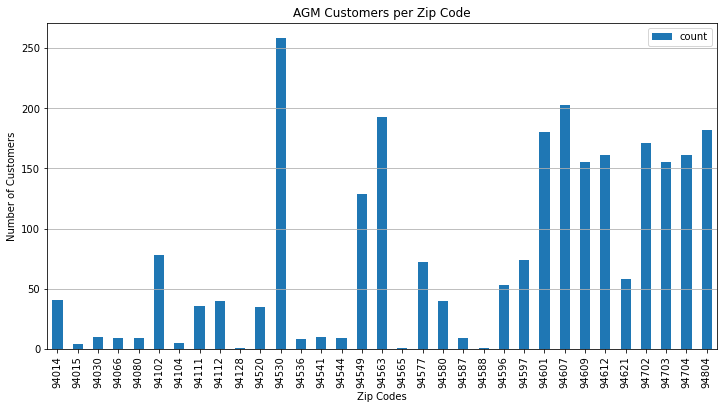

In [192]:
# ***********************************************************************************************************************
# 3. Prepare barplot of customer counts per zip code
# **********************************************************************************************************************

df_customers.set_index(df_customers['zip'],inplace=True)
df_customers.plot(kind='bar',figsize=(12,6),title='AGM Customers per Zip Code').grid(axis='y')
plt.xlabel('Zip Codes')
plt.ylabel('Number of Customers')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# **********************************************************************************************************************
# 4. Create neo4j graph of nodes for zip codes along with graph of stations 
#   -- can we make the thickness of the node circle change based on population density?
#   -- connect zip code nodes to station nodes with links indicating distance so distance from zip to station within 
#      same zip should be 0
#   -- refine further ... use customer address (and google maps api?) to compute actual distance to each BART station
# **********************************************************************************************************************

#### Business Scenario 2

Given traffic congestion "real time" data, compute shortest BART transportation path to avoid congestion

* Import traffic data either from Redis or canned file
* Update weights on links to make congested paths more costly
* Run shortest path (or other) algorithms
   
 (Traffic congestion data -- extreme, high, medium, low as input feed. Update transit times by
 factors of 100, 10, 2, 1. Run route planning algorithm based on congestion.)


In [ ]:
# **********************************************************************************************************************
# Business Scenario 2
#
# Given traffic congestion "real time" data, compute shortest 
# BART transportation path to avoid congestion
#
# Import traffic data either from Redis or canned file
# Update weights on links to make congested paths more costly
# Run shortest path (or other) algorithms
#   
# (Traffic congestion data -- extreme, high, medium, low as input feed. Update transit times by
# factors of 100, 10, 2, 1. Run route planning algorithm based on congestion.)
# *********************************************************************************************************************

In [ ]:
# ADD SCENARIO 2

#### Business Scenario 3
Given scheduled station closures and track segment out of service, re-evaluate best locations for popup locations or perhaps deploy delivery robots to pick up from those locations not accessible to customers and bring products to open locations. For example, if Oakland marathon is running with street closures, customers cannot access some areas of the city.

* Import schedule file (from Redis, MongoDB or canned CSV file)
* Use file remove stations from neo4j however do not remove associated pickup location thereby causing a dangling node without a link.
* Deploy mobile robots to dangling nodes and deliver product to nearest open pickup location
* Compute next nearest location also accounting for removed Links due to planned track maintenance

In [ ]:
# *********************************************************************************************************************
# Business Scenario 3
#
# Given scheduled station closures and track segment out of service,  
# re-evaluate best locations for popup locations or perhaps deploy
# delivery robots to pick up from those locations not accessible to
# customers and bring products to open locations.  For example, if
# Oakland marathon is running with street closures, customers cannot 
# access some areas of the city.
#
# Import schedule file (from Redis, MongoDB or canned CSV file)
# Use file remove stations from neo4j however do not remove associated pickup location 
#   thereby causing a dangling node without a link.
# Deploy mobile robots to dangling nodes and deliver product to nearest open pickup location
# Compute next nearest location also accounting for removed Links due to planned
#   track maintenance
#   
# ********************************************************************************************************************

In [ ]:
# ADD SCENARIO 3